In [1]:
#import os
#import sys
#import glob
import numpy as np
#import pandas as pd
#import operator as op
#import itertools as it
import scipy.linalg as la
#from pandas import DataFrame, Series
#from functools import reduce, partial
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_context("notebook", font_scale=1.5)
%matplotlib inline

In [2]:
#### Make test dataset (concentric spirals) ####
def testdata(n_cl, n_pt):
    clus = np.random.randint(0, n_cl, n_pt)  # Cluster ID
    theta = np.random.uniform(0, np.sqrt(n_pt / n_cl**3), n_pt) + 1  # Angle/radius
    xs = n_cl * theta * np.cos(theta + 2 * np.pi * clus / n_cl) + np.random.normal(0, np.pi/4, n_pt)
    ys = n_cl * theta * np.sin(theta + 2 * np.pi * clus / n_cl) + np.random.normal(0, np.pi/4, n_pt)
    return (np.column_stack([xs, ys]), clus)

n_cl = 5
n_pt = 5120
pts, clus = testdata(n_cl, n_pt)

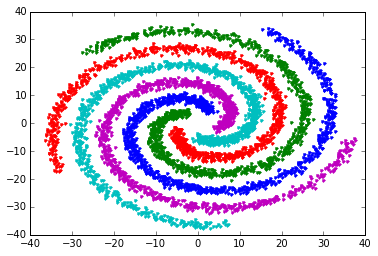

In [3]:
#### Plot test dataset ####
for c in range(n_cl):
    pc = np.array([pts[i] for i in range(n_pt) if clus[i]==c])
    plt.plot(pc[:,0], pc[:,1], '.')
plt.show()

In [4]:
#### Make scaled affinity matrix ####
def affmat(pts, sigma):
    A0 = np.sum((pts[None, :] - pts[:, None])**2, -1)  # Squared distance matrix
    A = np.exp(-A0 / (2 * sigma**2))
    np.fill_diagonal(A, 0)  # Affinity matrix
    D12 = np.diag(1 / np.sqrt(np.sum(A, 1)))  # Sums^(-1/2) for scaling
    return np.dot(np.dot(D12, A), D12)  # Scaled affinity matrix

L = affmat(pts, 0.5)

In [5]:
#### Find & scale k largest eigenvectors ####
def eigmat(L, k):
    X = la.eigh(L, eigvals=(n_pt-k, n_pt-1))[1][:, ::-1]  # k largest eigenvectors
    X1 = la.norm(X, axis=1)[:, None]  # Row norms for scaling
    return X / X1  # Scaled matrix of eigenvectors

Y = eigmat(L, n_cl)

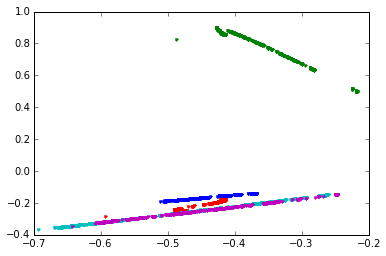

In [6]:
#### Plot first 2 dimensions to see transformed clusters ####
for c in range(n_cl):
    Yc = np.array([Y[i] for i in range(n_pt) if clus[i]==c])
    plt.plot(Yc[:,0], Yc[:,1], '.')
plt.show()

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


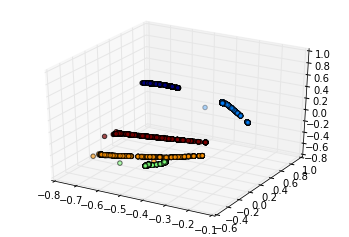

In [7]:
#### Plot first 3 dimensions to see transformed clusters ####
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Axes3D.scatter(ax, xs=Y[:,0], ys=Y[:, 1], zs=Y[:,2], c=clus)

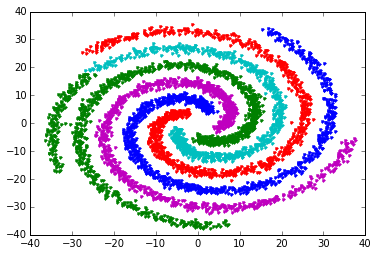

In [8]:
#### Try out K-Means (separate from K-Means++ part of project) ####
from sklearn.cluster import KMeans
km = KMeans(n_clusters=n_cl, n_jobs=-1)
kmcl = km.fit_predict(Y)
for c in range(n_cl):
    pc = np.array([pts[i] for i in range(n_pt) if kmcl[i]==c])
    plt.plot(pc[:,0], pc[:,1], '.')
plt.show()